# Extra Ideas
1) Use different scalers for X,Y and P
2) Somehow convert from 1D to 2D using the coordinates
3) Use more inputs

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
import joblib
from pathlib import Path
from tqdm import tqdm

import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

N_CSV_ROWS = 14184
LOOKBACK = 5
BATCH_SIZE = 128

WIDTH = 512
HEIGHT = 512

CSV_HEADER = ['ID', 'X', 'Y', 'Z', 'ABS_P', 
                'AIR_D', 'AIR_F', 'AIR_F_X', 'AIR_F_Y', 
                'P', 'P_C', 'BULK_T', 'THERM_C', 'TOTAL_E', 'TOTAL_P', 'TOTAL_T', 
                'TURB_E_D', 'TURB_E_F', 'TURB_I', 'TURB_K_E', 
                'VEL_U', 'VEL_U_GRAD', 'VEL_U_GRAD_X', 'VEL_U_GRAD_Y',
                'VEL_V', 'VEL_V_GRAD', 'VEL_V_GRAD_X', 'VEL_V_GRAD_Y',
                'VORT', 'WATER_F', 'WATER_F_X', 'WATER_F_Y', 'WATER_H_F', 'WATER_I_E', 'WATER_M_F', 'WATER_V_F'
                ]
INPUTS = ['P']
OUTPUTS = ['VEL_U', 'VEL_V']

def read_csv(filename, scaler):
    df = pd.read_csv(filename, skiprows=5, header=0, names=CSV_HEADER)
    df = df.dropna()

    dx = []
    dy = []
    for x_name in INPUTS:
        dx.append(df.pop(x_name))
    
    for y_name in OUTPUTS:
        dy.append(df.pop(y_name))

    dx = np.array(dx).T
    dy = np.array(dy).T

    if scaler:
        dx = scaler.transform(dx)
    return dx, dy

def shift_range(arr, new_range):
    fm = arr - np.min(arr)
    return (new_range-1) * (fm / np.max(fm))

def generate_permutations(n_timesteps, n_rows):
    return [(t, r) for t in np.arange(n_timesteps) for r in np.arange(n_rows)]

a = np.array(generate_permutations(5, 20))
b = np.array([x for x in itertools.product(range(5), range(20))])
print(np.array_equal(a, b))


True


In [110]:
def read_csv_2d(filename, scaler):
    df = pd.read_csv(filename, skiprows=5, header=0, names=CSV_HEADER)
    df = df.dropna()

    X = np.zeros((HEIGHT, WIDTH, len(INPUTS), 1))
    Y = np.zeros((HEIGHT, WIDTH, len(OUTPUTS), 2))
    all_x = shift_range(df['X'].values, WIDTH)
    all_y = shift_range(df['Y'].values, HEIGHT)
    all_p = shift_range(df['P'].values, 255)
    all_vu = df['VEL_U'].values
    all_vv = df['VEL_V'].values

    for csv_row_idx in range(df.shape[0]):
        fake_x = int(all_x[csv_row_idx])
        fake_y = int(all_y[csv_row_idx])

        X[fake_y, fake_x] = all_p[csv_row_idx]
        Y[fake_y, fake_x, 0] = all_vu[csv_row_idx]
        Y[fake_y, fake_x, 1] = all_vv[csv_row_idx]

    return X, Y

In [104]:
# Scaler
# Recreating takes around 3 minutes
SCALER_PATH = 'scaler.pkl'
SCALER_CREATION_DIRS = ['/home/jperez/datasets/sled250', '/home/jperez/datasets/sled300', '/home/jperez/datasets/sled350']
if os.path.exists(SCALER_PATH):
    print('Loading previous scaler')
    SCALER = joblib.load(SCALER_PATH)
else:
    print('Recreating scaler')
    SCALER = StandardScaler()
    for creation_dir in SCALER_CREATION_DIRS:
        for filepath in Path(creation_dir).glob('*.csv'):
            X, Y = read_csv(filepath, None)
            SCALER.partial_fit(X)
    joblib.dump(SCALER, SCALER_PATH)

Loading previous scaler


# Process Datasets

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Inspired from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class SledDataGenerator(keras.utils.Sequence):
    def __init__(self, data_dir, batch_size, lookback, shuffle, start, end, step=10):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.lookback = lookback
        self.shuffle = shuffle
        self.start = start
        self.end = end
        self.step = step
        
        # Check if we have a serialized version of the data, if not, generate it
        n_count = ((end-start)//step)+1
        data_path = f'{self.data_dir.stem}_{n_count}.npz'
        if os.path.exists(data_path):
            csv_data = np.load(data_path)
            self.x_data = csv_data['X']
            self.y_data = csv_data['Y']
        else:
            self.x_data = []
            self.y_data = []

            for timestep in tqdm(range(start, end, step)):
                X, Y = self.__read_csv__(timestep)
                self.x_data.append(X)
                self.y_data.append(Y)
            self.x_data = np.array(self.x_data)
            self.y_data = np.array(self.y_data)
            np.savez(data_path, X=self.x_data, Y=self.y_data)

        # Some sanity checks
        assert self.x_data.shape[1] == self.y_data.shape[1], 'x_data and y_data have a shape mismatch in the number of CSV rows'
        assert self.x_data.shape[1] == N_CSV_ROWS, f'N_CSV_ROWS does not match {self.x_data.shape[1]}'

        # Helpful variables
        self.n_timesteps = self.x_data.shape[0]
        self.n_nodes = self.x_data.shape[1]

        # Generate a list of the valid timesteps for batches
        self.list_timesteps = np.arange(lookback, self.n_timesteps)
        self.list_rows = np.arange(N_CSV_ROWS)
        self.list_IDs = [(t, r) for t in self.list_timesteps for r in self.list_rows]
        # self.list_IDs = [x for x in itertools.product(self.list_timesteps, self.list_rows)]
        
        self.on_epoch_end()

    def __len__(self):
        # return int(np.floor(len(self.list_timesteps) / self.batch_size))
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        batch_idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_pairs = [self.list_IDs[k] for k in batch_idxs]

        batch_x = []
        batch_y = []
        for (timestep, row) in batch_pairs:
            X = self.x_data[timestep-self.lookback:timestep, row]
            Y = self.y_data[timestep-self.lookback:timestep, row]

            batch_x.append(X)
            batch_y.append(Y)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __read_csv__(self, timestep):
        filename = os.path.join(self.data_dir, f'export{timestep}.csv')
        return read_csv(filename, SCALER)

train_generator = SledDataGenerator('/home/jperez/datasets/sled250', batch_size=64, lookback=LOOKBACK, shuffle=True, start=10, end=7700+10)
val_generator = SledDataGenerator('/home/jperez/datasets/sled300', batch_size=64, lookback=LOOKBACK, shuffle=True, start=10, end=7410+10)

In [65]:
train_generator.x_data.shape

(770, 14184, 1)

In [106]:
print(train_generator[0][0].shape)
print(train_generator[0][1].shape)
print(len(train_generator.list_timesteps) * N_CSV_ROWS)

print('X=', train_generator[0][:])
print('Y=', train_generator[0][:])

(64, 5, 1)
(64, 5, 2)
10850760
X= (array([[[-1.11829468e-01],
        [-1.11879304e-01],
        [-1.11923256e-01],
        [-1.11958823e-01],
        [-1.12018641e-01]],

       [[-1.34247213e-01],
        [-1.34082534e-01],
        [-1.34707270e-01],
        [-1.34101791e-01],
        [-1.34018255e-01]],

       [[-1.30253241e-01],
        [-1.30251806e-01],
        [-1.30250187e-01],
        [-1.30247283e-01],
        [-1.30246186e-01]],

       [[-1.17151498e-01],
        [-1.17211412e-01],
        [-1.17296126e-01],
        [-1.17362178e-01],
        [-1.17429448e-01]],

       [[-1.50102939e-01],
        [-1.46720772e-01],
        [-1.49230893e-01],
        [-1.48939134e-01],
        [-1.49146628e-01]],

       [[ 4.04707401e-02],
        [ 4.08491454e-02],
        [ 4.20842344e-02],
        [ 4.15840542e-02],
        [ 4.28469983e-02]],

       [[-1.32616187e-01],
        [-1.31949525e-01],
        [-1.31301166e-01],
        [-1.31113415e-01],
        [-1.32649422e-01]],

      

In [107]:
# https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

model = keras.Sequential()

model.add(keras.layers.LSTM(128, input_shape=(5, len(INPUTS)), return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(len(OUTPUTS))))

model.compile(
    loss=keras.losses.MeanSquaredLogarithmicError(),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.MeanSquaredError()]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 2)              258       
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
# checkpoint = keras.callbacks.ModelCheckpoint('LSTM_v2.hdf5',
#                                              verbose=1,
#                                              monitor='val_loss',
#                                              save_best_only=True,
#                                              mode='auto')
history = model.fit(
    x=train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=len(train_generator)
)

# 2D Experiments

In [106]:
df = pd.read_csv(os.path.join('/home/jperez/datasets/sled250', f'export10.csv'), skiprows=5, header=0, names=CSV_HEADER)

-0.02500000039999999979 | 3.97499989999999980839 | 14184
-0.00000000000000048372 | 2.20000004999999987376 | 14184
0.00000000000000000000 | 27026296.00000000000000000000 | 14184
-106.96876500000000476120 | 520.52038600000003043533 | 14184
-285.01266500000002679371 | 725.59051499999998213752 | 14184


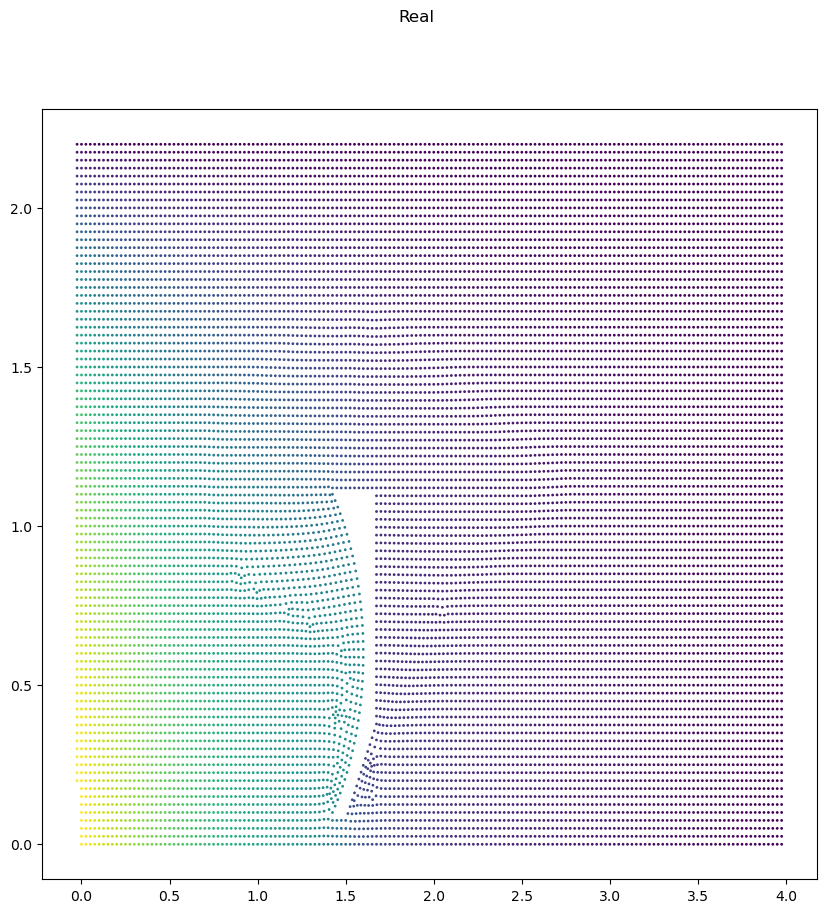

-0.02500000039999999979 | 3.97499989999999980839
-0.00000000000000048372 | 2.20000004999999987376
0.00000000000000000000 | 511.00000000000000000000
0.00000000000000000000 | 511.00000000000000000000


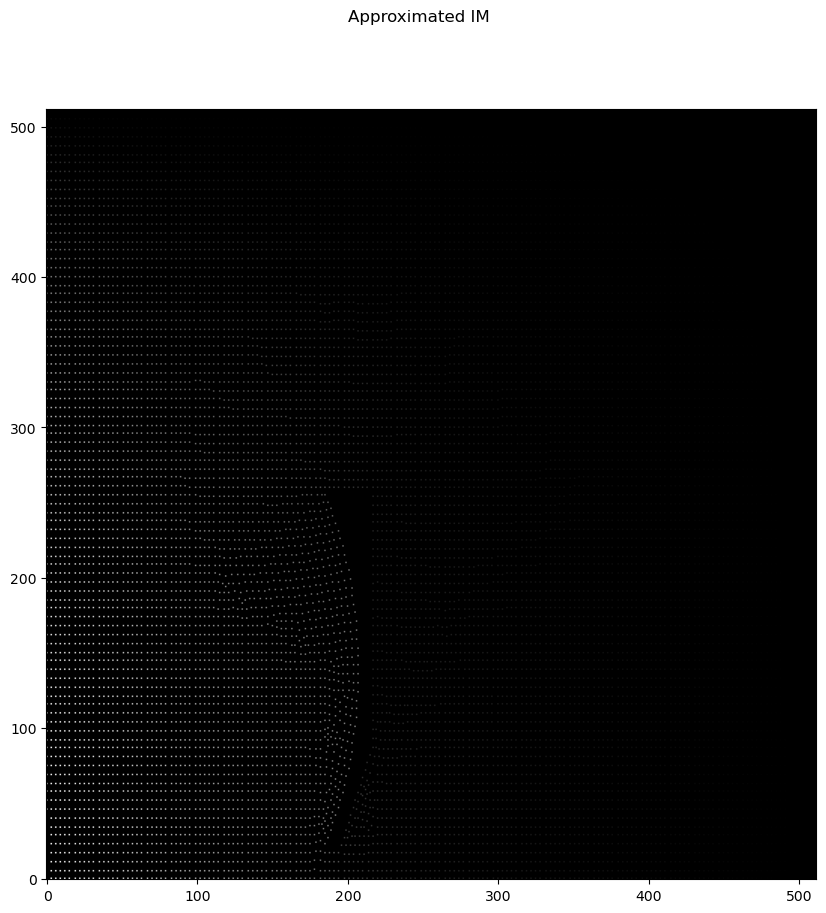

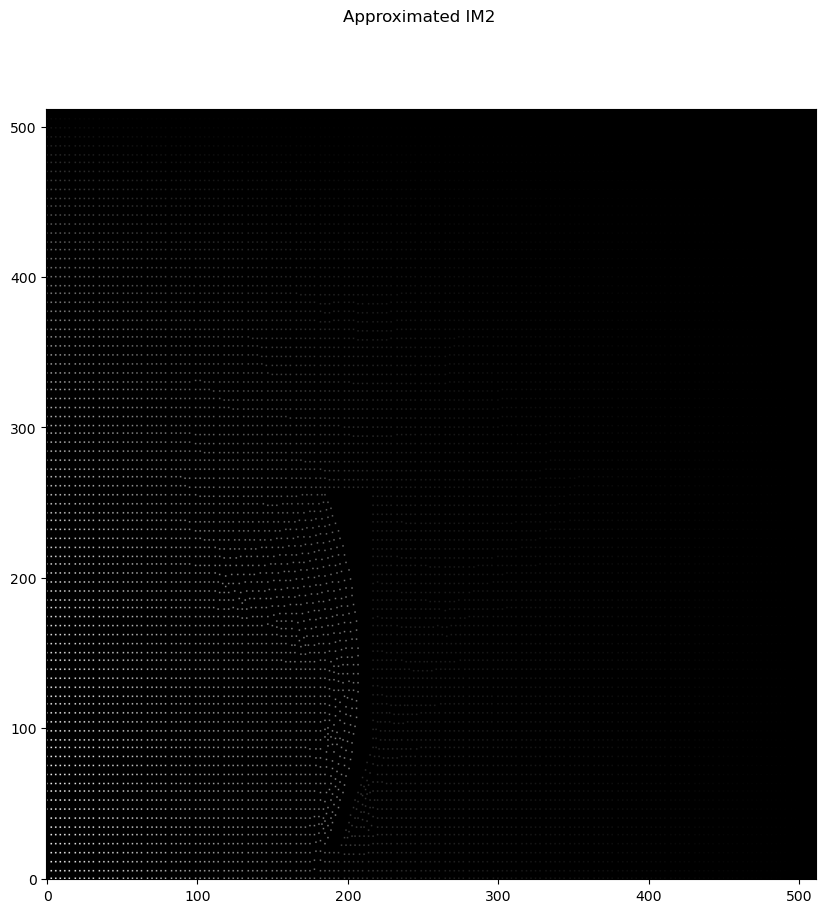

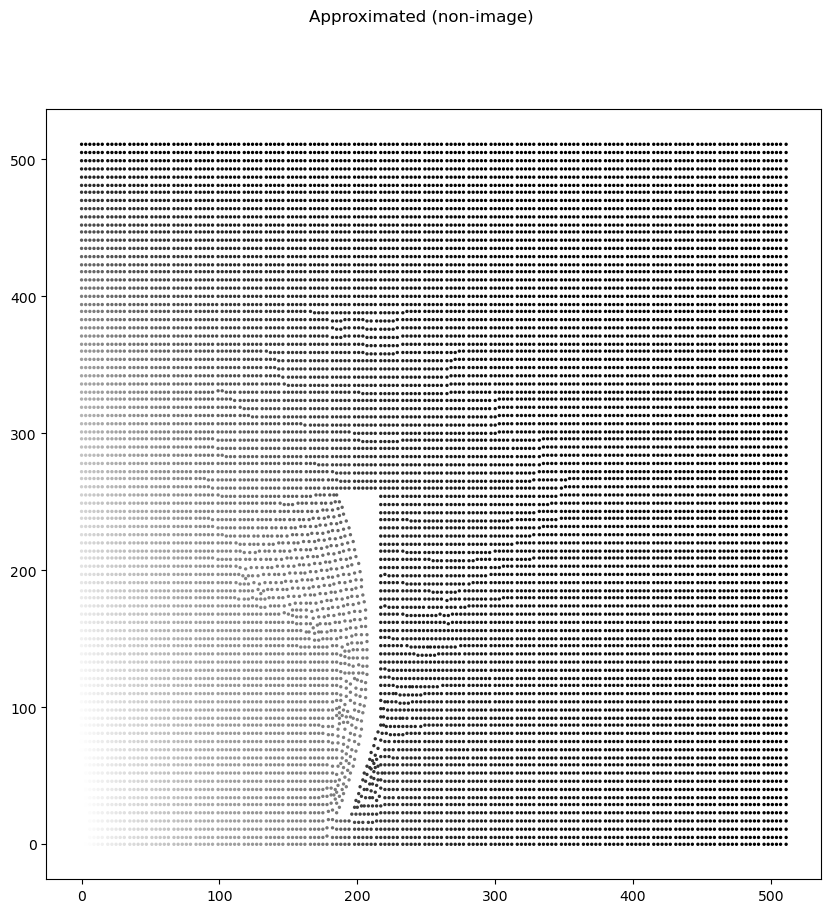

In [111]:
df = pd.read_csv(os.path.join('/home/jperez/datasets/sled250', f'export10.csv'), skiprows=5, header=0, names=CSV_HEADER)
df = df.dropna()

X = df['X']
Y = df['Y']
P = df['P']
VU = df['VEL_U']
VV = df['VEL_V']

for Q in [X, Y, P, VU, VV]:
    print(f'{np.min(Q):.20f} | {np.max(Q):.20f} | {len(Q)}')

plt.figure(figsize=(10,10))
plt.suptitle('Real')
plt.scatter(X, Y, c=P, s=1)
plt.show()

WIDTH = 512
HEIGHT = 512

# Convert to the [WIDTH, HEIGHT] range
X = shift_range(X, WIDTH)
Y = shift_range(Y, HEIGHT)

print(f'{np.min(df["X"]):.20f} | {np.max(df["X"]):.20f}')
print(f'{np.min(df["Y"]):.20f} | {np.max(df["Y"]):.20f}')

PX = [d for d in map(lambda x: int(x), X.to_numpy())]
PY = [d for d in map(lambda y: int(y), Y.to_numpy())]

# Image stuff
df['X'] = shift_range(df['X'], WIDTH)
df['Y'] = shift_range(df['Y'], HEIGHT)
df['P'] = shift_range(df['P'], 255)

print(f'{np.min(df["X"]):.20f} | {np.max(df["X"]):.20f}')
print(f'{np.min(df["Y"]):.20f} | {np.max(df["Y"]):.20f}')

im = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
for idx in range(len(df)):
    node = df.iloc[idx]
    
    real_x = node['X']
    real_y = node['Y']

    fake_x = int(real_x)
    fake_y = int(real_y)

    im[fake_y, fake_x] = node['P']

im2 = read_csv_2d(os.path.join('/home/jperez/datasets/sled250', f'export10.csv'), None)

plt.figure(figsize=(10,10))
plt.suptitle('Approximated IM')
plt.imshow(im, origin='lower', cmap='gray')
plt.show()

plt.figure(figsize=(10,10))
plt.suptitle('Approximated IM2')
plt.imshow(im2[0].reshape((HEIGHT, WIDTH, -1)), origin='lower', cmap='gray')
plt.show()

plt.figure(figsize=(10,10))
plt.suptitle('Approximated (non-image)')
plt.scatter(PX, PY, c=P, s=2, cmap='gray')
plt.show()

In [87]:
im.shape

(512, 512)

In [116]:
print(im.shape, im2[0].reshape(HEIGHT, WIDTH).shape)
np.array_equal(im, im2[0].reshape(HEIGHT, WIDTH))

(512, 512) (512, 512)


False

In [44]:
print(X[:5])

0    3.469447e-17
1    4.293441e-17
2   -2.500000e-02
3   -2.500000e-02
4    3.306275e-17
Name: X, dtype: float64


(14184,) <class 'pandas.core.series.Series'>


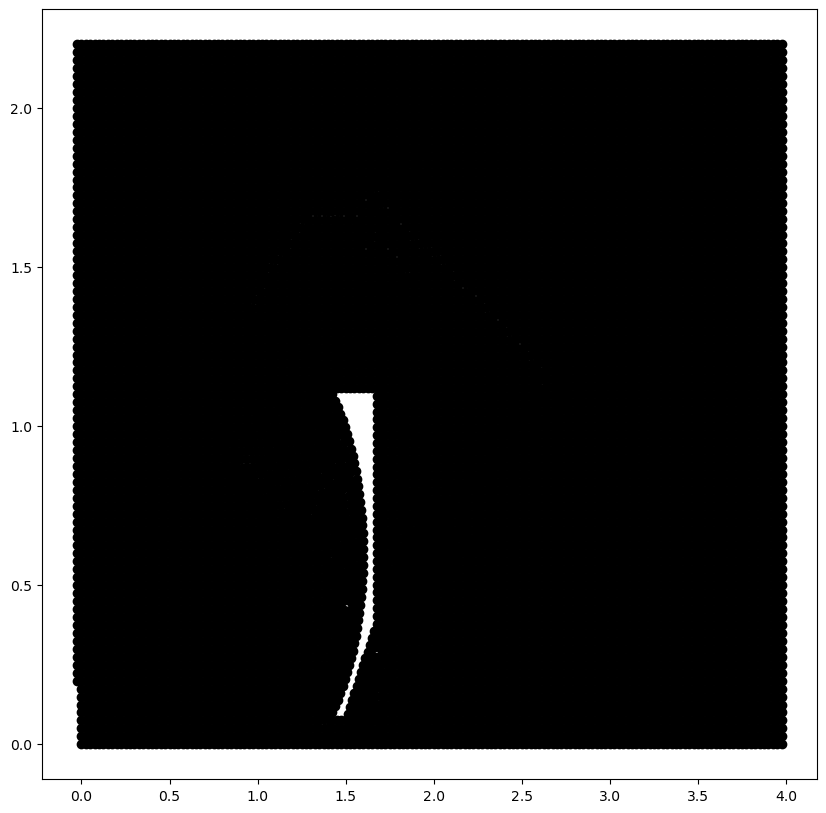

In [57]:
print(X.shape, type(X))
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, c='black')
# plt.scatter(X, P, c='r')
# plt.scatter(X, VU, c='g')
# plt.scatter(X, VV, c='b')
plt.show()

In [66]:
# x_space, y_space = np.mgrid[np.min(Y):np.max(Y):complex(len(Y)), np.min(X):np.max(X):complex(len(X))]

# plt.figure()
# plt.scatter(x_space, y_space)
# plt.show()

In [42]:
print(f'{np.min(X):.20f} | {np.max(X):.20f}')
print(f'{np.min(Y):.20f} | {np.max(Y):.20f}')

WIDTH = 28
HEIGHT = 28

# Convert to the [WIDTH, HEIGHT] range
fm = X - np.min(X)
X = WIDTH * (fm / np.max(X))

fm = Y - np.min(Y)
Y = HEIGHT * (fm / np.max(Y))

print(f'{np.min(X):.20f} | {np.max(X):.20f}')
print(f'{np.min(Y):.20f} | {np.max(Y):.20f}')

plt.figure(figsize=(10, 10))
plt.scatter(X, Y)
plt.show()

0.0 0.0 0.0
